In [6]:
import json
import os
import re
from pathlib import Path
from typing import Dict, List, Tuple, Any
import pandas as pd
from gatenlp import Document
from gatenlp.corpora import ListCorpus
from GatenlpUtils import loadCorpus

class LLMEventResultsEvaluator:
    """
    Evaluates LLM event annotation results by comparing predictions against 
    gold standard consensus annotations in GateNLP documents.
    """
    
    def __init__(self, output_dir: str = "output", corpus=None):
        self.output_dir = Path(output_dir)
        self.corpus = corpus if corpus is not None else loadCorpus()
        self.evaluation_results = []
        
        # Event-related annotation types to evaluate based on consensus annotation set
        self.event_annotation_types = [
            "Event",      # General event annotation
            "Event_who",  # Who annotation 
            "Event_what", # What annotation
            "Event_when"  # When annotation
        ]
        
    def find_result_folders(self) -> List[Path]:
        """Find all timestamped result folders in output directory."""
        folders = []
        if self.output_dir.exists():
            # Check if output_dir itself is a timestamped folder
            if re.match(r'.*\d{8}_\d{6}', self.output_dir.name):
                # We're pointing directly to a timestamped folder
                folders.append(self.output_dir)
            else:
                # Look for timestamped folders within the output directory
                for item in self.output_dir.iterdir():
                    if item.is_dir() and re.match(r'\d{8}_\d{6}', item.name):
                        folders.append(item)
        return sorted(folders)
    
    def find_result_jsons(self, folder: Path) -> List[Path]:
        """Find all result JSON files (excluding pipeline_results_*.json)."""
        jsons = []
        for json_file in folder.glob("*.json"):
            if not json_file.name.startswith("pipeline_results_"):
                jsons.append(json_file)
        return jsons
    
    def extract_doc_name_from_path(self, file_path: str) -> str:
        """Extract document name from file path for matching with corpus."""
        return Path(file_path).stem
    
    def find_corpus_document(self, doc_identifier: str) -> Document:
        """Find corresponding document in corpus."""
        for doc in self.corpus:
            doc_name = doc.features.get("gate.SourceURL", "")
            if (doc_identifier in doc_name or 
                doc_name.endswith(f"{doc_identifier}.xml") or
                Path(doc_name).stem == doc_identifier):
                return doc
        return None
    
    def parse_llm_event_predictions(self, result_data: Dict[str, Any]) -> Dict[str, Dict[str, List[Dict]]]:
        """
        Parse LLM event predictions from result JSON.
        Maps JSON events to consensus annotation types:
        - "event" in JSON -> "Event" in consensus
        - "event_who" in JSON -> "Event_who" in consensus
        - "event_what" in JSON -> "Event_what" in consensus  
        - "event_when" in JSON -> "Event_when" in consensus
        - "event_type" in JSON -> type metadata of "Event" annotation
        """
        predictions = {}
        
        # Check if annotations array exists
        if "annotations" not in result_data:
            print("No 'annotations' key found in result data")
            return predictions
        
        # Process each model's annotations
        for model_annotation in result_data["annotations"]:
            if not isinstance(model_annotation, dict):
                continue
                
            model_name = model_annotation.get("model_name", "unknown_model")
            predictions[model_name] = {}
            
            # Initialize all event annotation types
            for ann_type in self.event_annotation_types:
                predictions[model_name][ann_type] = []
            
            # Extract events from this model's results
            if "events" in model_annotation:
                events = model_annotation["events"]
                for event in events:
                    if isinstance(event, dict):
                        source_text = event.get("source_text", "")
                        
                        # Map "event" field to "Event" annotation
                        if "event" in event:
                            event_type = event.get("event_type", "")
                            # Remove "event_" prefix from event_type to match consensus type metadata
                            if event_type.startswith("event_"):
                                event_type = event_type[6:]  # Remove "event_" prefix
                            elif event_type.startswith("Event_"):
                                event_type = event_type[6:]  # Remove "Event_" prefix
                            
                            ann_dict = {
                                "start": 0,  # Will be calculated from source_text
                                "end": 0,    # Will be calculated from source_text
                                "features": {
                                    "source_text": source_text,
                                    "type": event_type,  # This will be compared to consensus Event type metadata
                                    "event_value": event.get("event", "")
                                }
                            }
                            predictions[model_name]["Event"].append(ann_dict)
                        
                        # Map "event_who" field to "Event_who" annotation
                        if "event_who" in event:
                            ann_dict = {
                                "start": 0,
                                "end": 0,
                                "features": {
                                    "source_text": source_text,
                                    "event_who_value": event.get("event_who", "")
                                }
                            }
                            predictions[model_name]["Event_who"].append(ann_dict)
                        
                        # Map "event_what" field to "Event_what" annotation
                        if "event_what" in event:
                            ann_dict = {
                                "start": 0,
                                "end": 0,
                                "features": {
                                    "source_text": source_text,
                                    "event_what_value": event.get("event_what", "")
                                }
                            }
                            predictions[model_name]["Event_what"].append(ann_dict)
                        
                        # Map "event_when" field to "Event_when" annotation
                        if "event_when" in event:
                            ann_dict = {
                                "start": 0,
                                "end": 0,
                                "features": {
                                    "source_text": source_text,
                                    "event_when_value": event.get("event_when", "")
                                }
                            }
                            predictions[model_name]["Event_when"].append(ann_dict)
        
        return predictions
    
    def calculate_text_positions(self, source_text: str, document_text: str) -> Tuple[int, int]:
        """
        Calculate start and end positions of source_text within document_text.
        Returns: (start, end) positions or (0, 0) if not found.
        """
        if not source_text or not document_text:
            return (0, 0)
        
        # Clean up the source text for better matching
        cleaned_source = source_text.strip()
        
        # Try to find the text in the document
        start_pos = document_text.find(cleaned_source)
        if start_pos != -1:
            end_pos = start_pos + len(cleaned_source)
            return (start_pos, end_pos)
        
        # If exact match fails, try with normalized whitespace
        import re
        normalized_source = re.sub(r'\s+', ' ', cleaned_source)
        normalized_doc = re.sub(r'\s+', ' ', document_text)
        
        start_pos = normalized_doc.find(normalized_source)
        if start_pos != -1:
            # Find the actual positions in the original text
            # This is a simplified approach - might need refinement
            end_pos = start_pos + len(normalized_source)
            return (start_pos, end_pos)
        
        return (0, 0)
    
    def extract_annotations_from_response(self, response_text: str) -> Dict[str, List[Dict]]:
        """
        Extract event annotations from LLM response text.
        Adjust this method based on your actual LLM response format.
        """
        annotations = {}
        for ann_type in self.event_annotation_types:
            annotations[ann_type] = []
        
        # Example parsing - adjust based on your actual response format
        # This assumes annotations are in JSON format within the response
        try:
            # Try to find JSON blocks in the response
            json_matches = re.findall(r'\{.*?\}', response_text, re.DOTALL)
            for json_str in json_matches:
                try:
                    parsed_json = json.loads(json_str)
                    if isinstance(parsed_json, dict):
                        for ann_type in self.event_annotation_types:
                            if ann_type in parsed_json:
                                annotations[ann_type].extend(parsed_json[ann_type])
                except json.JSONDecodeError:
                    continue
        except Exception as e:
            print(f"Error parsing annotations from response: {e}")
        
        return annotations
    
    def add_prediction_annotations(self, doc: Document, model_name: str, 
                                 predictions: Dict[str, List[Dict]]):
        """Add prediction annotations to document as new annotation set."""
        annset_name = f"{model_name}_predictions"
        annset = doc.annset(annset_name)
        
        # Clear any existing annotations in this set
        annset.clear()
        
        # Add predicted event annotations
        for ann_type, ann_list in predictions.items():
            for ann_dict in ann_list:
                try:
                    # Extract start, end, and features from annotation dict
                    start = ann_dict.get("start", 0)
                    end = ann_dict.get("end", 0)
                    features = ann_dict.get("features", {})
                    
                    # If start/end positions are not provided or are 0, try to calculate from source text
                    if start == 0 and end == 0 and "source_text" in features:
                        source_text = features["source_text"]
                        if source_text:
                            start, end = self.calculate_text_positions(source_text, doc.text)
                    
                    # Ensure boundaries are within document bounds
                    start = max(0, min(start, len(doc.text)))
                    end = max(start, min(end, len(doc.text)))
                    
                    # Add features indicating source
                    features.update({
                        "source": "llm_prediction",
                        "model": model_name
                    })
                    
                    annset.add(start, end, ann_type, features)
                    
                except Exception as e:
                    print(f"Error adding annotation {ann_dict}: {e}")
    
    def calculate_annotation_overlap_metrics(self, gold_annset, pred_annset, ann_type: str) -> Dict[str, float]:
        """Calculate precision, recall, F1 for a specific annotation type."""
        gold_anns = list(gold_annset.with_type(ann_type))
        pred_anns = list(pred_annset.with_type(ann_type))
        
        if not gold_anns and not pred_anns:
            return {"precision": 1.0, "recall": 1.0, "f1": 1.0, "gold_count": 0, "pred_count": 0}
        
        if not pred_anns:
            return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "gold_count": len(gold_anns), "pred_count": 0}
        
        if not gold_anns:
            return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "gold_count": 0, "pred_count": len(pred_anns)}
        
        # Calculate token-level overlap
        gold_tokens = set()
        pred_tokens = set()
        
        # For Event annotations, also consider type metadata matching
        if ann_type == "Event":
            # Create sets of (start, end, type) tuples for exact matching
            gold_spans_with_type = set()
            pred_spans_with_type = set()
            
            for ann in gold_anns:
                ann_type_meta = ann.features.get("type", "")
                for pos in range(ann.start, ann.end):
                    gold_spans_with_type.add((pos, ann_type_meta))
                    
            for ann in pred_anns:
                ann_type_meta = ann.features.get("type", "")
                for pos in range(ann.start, ann.end):
                    pred_spans_with_type.add((pos, ann_type_meta))
            
            # Calculate overlap considering both position and type
            true_positives = len(gold_spans_with_type.intersection(pred_spans_with_type))
            
            precision = true_positives / len(pred_spans_with_type) if pred_spans_with_type else 0
            recall = true_positives / len(gold_spans_with_type) if gold_spans_with_type else 0
            
        else:
            # For other annotation types, use token-level overlap only
            for ann in gold_anns:
                gold_tokens.update(range(ann.start, ann.end))
            
            for ann in pred_anns:
                pred_tokens.update(range(ann.start, ann.end))
            
            true_positives = len(gold_tokens.intersection(pred_tokens))
            precision = true_positives / len(pred_tokens) if pred_tokens else 0
            recall = true_positives / len(gold_tokens) if gold_tokens else 0
        
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "gold_count": len(gold_anns),
            "pred_count": len(pred_anns),
            "true_positives": true_positives if ann_type != "Event" else len(gold_spans_with_type.intersection(pred_spans_with_type)),
            "gold_tokens": len(gold_tokens) if ann_type != "Event" else len(gold_spans_with_type),
            "pred_tokens": len(pred_tokens) if ann_type != "Event" else len(pred_spans_with_type)
        }
    
    def evaluate_document(self, doc: Document, doc_name: str, result_folder: str) -> List[Dict]:
        """Evaluate all model predictions for a single document against consensus annotations."""
        gold_annset = doc.annset("consensus")  # Use consensus annotation set as gold standard
        
        if not gold_annset:
            print(f"Warning: No 'consensus' annotation set found in document {doc_name}")
            return []
        
        results = []
        
        # Get all prediction annotation sets
        pred_annset_names = [name for name in doc.annset_names() if name.endswith("_predictions")]
        
        for annset_name in pred_annset_names:
            model_name = annset_name.replace("_predictions", "")
            pred_annset = doc.annset(annset_name)
            
            # Evaluate each event annotation type
            for ann_type in self.event_annotation_types:
                metrics = self.calculate_annotation_overlap_metrics(gold_annset, pred_annset, ann_type)
                
                result = {
                    "result_folder": result_folder,
                    "document": doc_name,
                    "model": model_name,
                    "annotation_type": ann_type,
                    **metrics
                }
                results.append(result)
        
        return results
    
    def process_result_json(self, json_path: Path, result_folder: str):
        """Process a single result JSON file."""
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                result_data = json.load(f)
        except Exception as e:
            print(f"Error reading {json_path}: {e}")
            return
        
        # Extract document identifier
        doc_path = result_data.get("Document", "")
        doc_name = self.extract_doc_name_from_path(doc_path)
        
        # Find corresponding corpus document
        corpus_doc = self.find_corpus_document(doc_name)
        if corpus_doc is None:
            print(f"Warning: Could not find corpus document for {doc_name}")
            return
        
        # Parse LLM event predictions
        predictions = self.parse_llm_event_predictions(result_data)
        
        if not predictions:
            print(f"Warning: No predictions found in {json_path.name}")
            return
        
        # Debug: Print what we found
        print(f"Found predictions for models: {list(predictions.keys())}")
        for model_name, model_preds in predictions.items():
            total_events = sum(len(events) for events in model_preds.values())
            print(f"  {model_name}: {total_events} total events")
            for ann_type, events in model_preds.items():
                if events:
                    print(f"    {ann_type}: {len(events)} events")
        
        # Add prediction annotations to document
        for model_name, model_predictions in predictions.items():
            self.add_prediction_annotations(corpus_doc, model_name, model_predictions)
        
        # Evaluate predictions against consensus annotations
        doc_results = self.evaluate_document(corpus_doc, doc_name, result_folder)
        self.evaluation_results.extend(doc_results)
        
        print(f"Processed {json_path.name}: {len(predictions)} models, {len(doc_results)} evaluations")
    
    def run_evaluation(self) -> pd.DataFrame:
        """Run complete evaluation on all result folders."""
        result_folders = self.find_result_folders()
        
        if not result_folders:
            print("No result folders found in output directory")
            return pd.DataFrame()
        
        print(f"Found {len(result_folders)} result folders")
        
        for folder in result_folders:
            print(f"\nProcessing folder: {folder.name}")
            result_jsons = self.find_result_jsons(folder)
            
            for json_path in result_jsons:
                self.process_result_json(json_path, folder.name)
        
        # Convert results to DataFrame
        if self.evaluation_results:
            df = pd.DataFrame(self.evaluation_results)
            return df
        else:
            print("No evaluation results generated")
            return pd.DataFrame()
    
    def generate_summary_report(self, results_df: pd.DataFrame) -> str:
        """Generate summary report of evaluation results."""
        if results_df.empty:
            return "No results to summarize"
        
        report = []
        report.append("LLM Event Annotation Evaluation Summary")
        report.append("=" * 60)
        
        # Overall statistics
        total_evaluations = len(results_df)
        unique_models = results_df['model'].nunique()
        unique_docs = results_df['document'].nunique()
        unique_ann_types = results_df['annotation_type'].nunique()
        
        report.append(f"Total evaluations: {total_evaluations}")
        report.append(f"Unique models: {unique_models}")
        report.append(f"Unique documents: {unique_docs}")
        report.append(f"Annotation types evaluated: {unique_ann_types}")
        report.append("")
        
        # Average F1 by model
        report.append("Average F1 Scores by Model:")
        model_f1 = results_df.groupby('model')['f1'].mean().sort_values(ascending=False)
        for model, f1 in model_f1.items():
            report.append(f"  {model}: {f1:.3f}")
        report.append("")
        
        # Average F1 by annotation type
        report.append("Average F1 Scores by Annotation Type:")
        ann_type_f1 = results_df.groupby('annotation_type')['f1'].mean().sort_values(ascending=False)
        for ann_type, f1 in ann_type_f1.items():
            report.append(f"  {ann_type}: {f1:.3f}")
        report.append("")
        
        # Best performing model-annotation combinations
        report.append("Best Model-Annotation Combinations (Top 10 F1):")
        best_combinations = results_df.groupby(['model', 'annotation_type'])['f1'].mean().sort_values(ascending=False).head(10)
        for (model, ann_type), f1 in best_combinations.items():
            report.append(f"  {model} - {ann_type}: {f1:.3f}")
        report.append("")
        
        # Detailed precision/recall breakdown
        report.append("Detailed Metrics by Annotation Type:")
        for ann_type in results_df['annotation_type'].unique():
            ann_data = results_df[results_df['annotation_type'] == ann_type]
            avg_precision = ann_data['precision'].mean()
            avg_recall = ann_data['recall'].mean()
            avg_f1 = ann_data['f1'].mean()
            total_gold = ann_data['gold_count'].sum()
            total_pred = ann_data['pred_count'].sum()
            
            report.append(f"  {ann_type}:")
            report.append(f"    Precision: {avg_precision:.3f}")
            report.append(f"    Recall: {avg_recall:.3f}")
            report.append(f"    F1: {avg_f1:.3f}")
            report.append(f"    Total gold annotations: {total_gold}")
            report.append(f"    Total predicted annotations: {total_pred}")
        
        return "\n".join(report)

def main():
    """Main execution function."""
    print("Starting LLM Event Annotation Results Evaluation...")
    
    # Specify which output folder to evaluate
    # Option 1: Evaluate all timestamped folders in output/
    # output_dir = "output"
    
    # Option 2: Evaluate only a specific timestamped folder
    output_dir = "output/pipeline_results_20250718_085458"
    
    evaluator = LLMEventResultsEvaluator(output_dir=output_dir)
    
    # Run evaluation
    results_df = evaluator.run_evaluation()
    
    if not results_df.empty:
        # Save results
        output_path = "output/llm_event_evaluation_results.csv"
        results_df.to_csv(output_path, index=False)
        print(f"\nEvaluation results saved to: {output_path}")
        
        # Generate and save summary report
        summary = evaluator.generate_summary_report(results_df)
        summary_path = "output/llm_event_evaluation_summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary)
        print(f"Summary report saved to: {summary_path}")
        
        # Print summary to console
        print("\n" + summary)
        
        # Display some basic statistics
        print("\nDetailed Results Preview:")
        print(results_df.head(15).to_string(index=False))
        
    else:
        print("No results generated. Check if result folders and JSON files exist.")

if __name__ == "__main__":
    main()

Starting LLM Event Annotation Results Evaluation...
Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded i

Starting LLM Event Annotation Results Evaluation...
Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded i

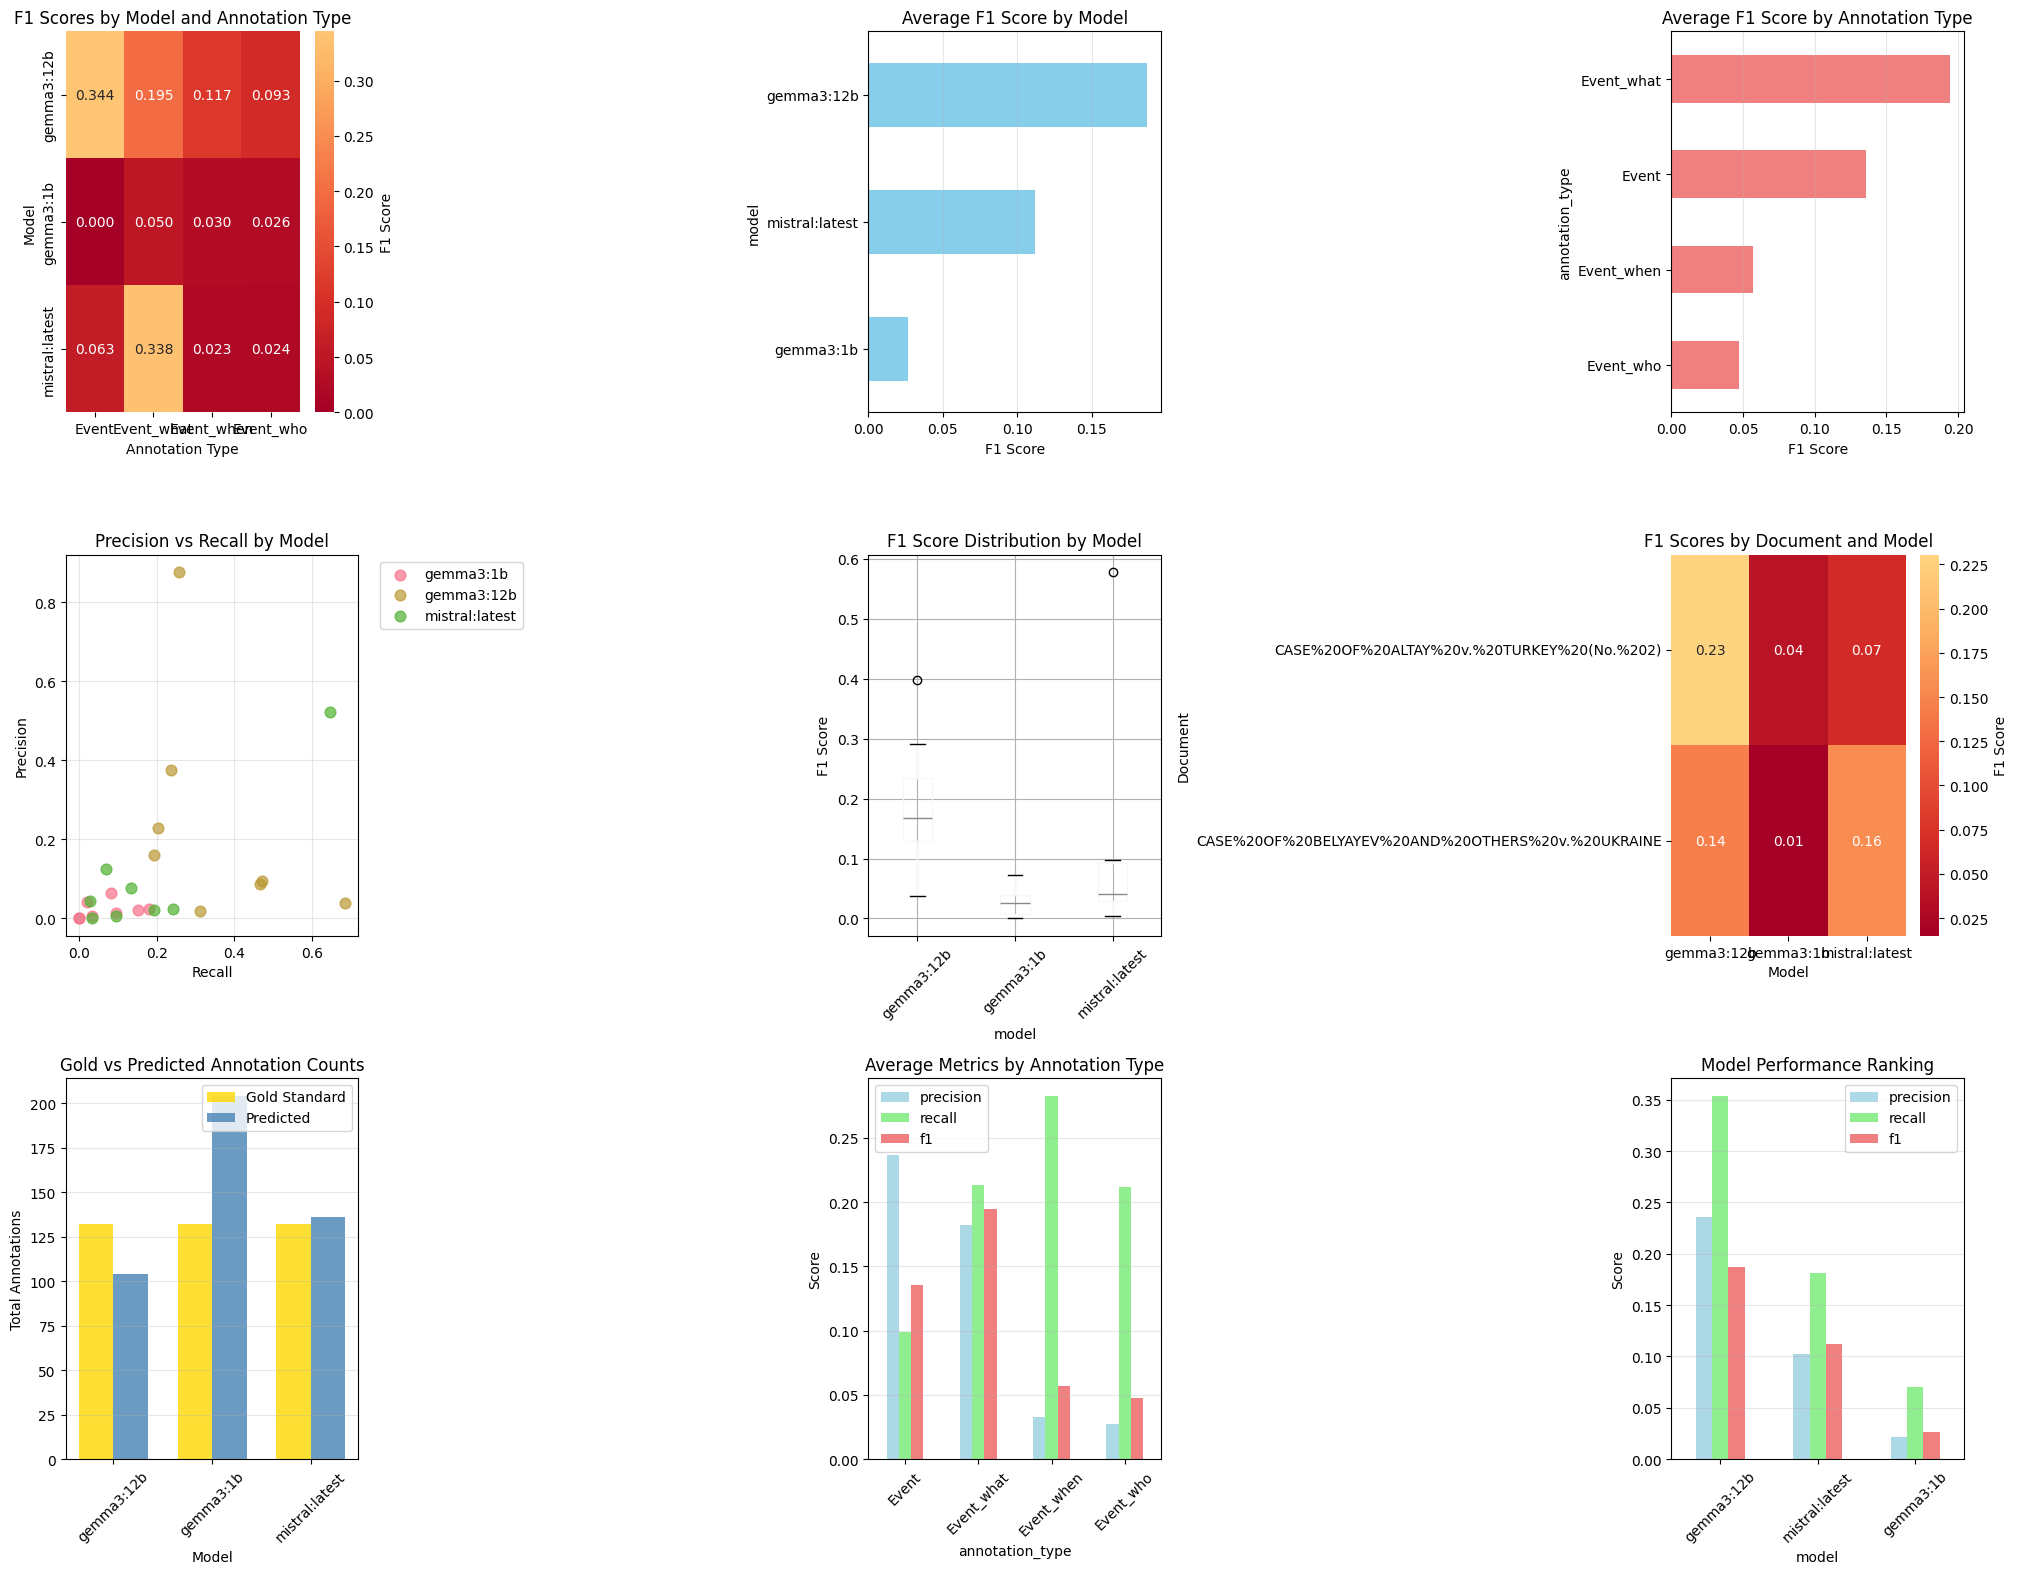



📊 QUICK STATS:
Total evaluations: 24
Models evaluated: 3
Documents processed: 2
Annotation types: Event, Event_who, Event_what, Event_when
Average F1 score: 0.109
Best performing model: gemma3:12b
Best annotation type: Event_what


In [7]:
# Visual Analysis and Better Results Overview
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_visual_analysis(results_df: pd.DataFrame):
    """Create comprehensive visual analysis of the evaluation results."""
    
    if results_df.empty:
        print("No results to visualize")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Heatmap: F1 scores by Model and Annotation Type
    plt.subplot(3, 3, 1)
    pivot_f1 = results_df.pivot_table(values='f1', index='model', columns='annotation_type', aggfunc='mean')
    sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
                cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Scores by Model and Annotation Type')
    plt.xlabel('Annotation Type')
    plt.ylabel('Model')
    
    # 2. Bar plot: Average F1 by Model
    plt.subplot(3, 3, 2)
    model_f1 = results_df.groupby('model')['f1'].mean().sort_values(ascending=True)
    model_f1.plot(kind='barh', color='skyblue')
    plt.title('Average F1 Score by Model')
    plt.xlabel('F1 Score')
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Bar plot: Average F1 by Annotation Type
    plt.subplot(3, 3, 3)
    ann_f1 = results_df.groupby('annotation_type')['f1'].mean().sort_values(ascending=True)
    ann_f1.plot(kind='barh', color='lightcoral')
    plt.title('Average F1 Score by Annotation Type')
    plt.xlabel('F1 Score')
    plt.grid(axis='x', alpha=0.3)
    
    # 4. Precision vs Recall scatter plot
    plt.subplot(3, 3, 4)
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        plt.scatter(model_data['recall'], model_data['precision'], 
                   label=model, alpha=0.7, s=60)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall by Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    
    # 5. Distribution of F1 scores
    plt.subplot(3, 3, 5)
    results_df.boxplot(column='f1', by='model', ax=plt.gca())
    plt.title('F1 Score Distribution by Model')
    plt.suptitle('')  # Remove the default title
    plt.xticks(rotation=45)
    plt.ylabel('F1 Score')
    
    # 6. Document-level performance heatmap
    plt.subplot(3, 3, 6)
    doc_model_f1 = results_df.groupby(['document', 'model'])['f1'].mean().reset_index()
    doc_model_pivot = doc_model_f1.pivot(index='document', columns='model', values='f1')
    sns.heatmap(doc_model_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0.3,
                cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Scores by Document and Model')
    plt.xlabel('Model')
    plt.ylabel('Document')
    
    # 7. Gold vs Predicted annotations count
    plt.subplot(3, 3, 7)
    total_gold = results_df.groupby('model')['gold_count'].sum()
    total_pred = results_df.groupby('model')['pred_count'].sum()
    
    x = np.arange(len(total_gold))
    width = 0.35
    
    plt.bar(x - width/2, total_gold.values, width, label='Gold Standard', color='gold', alpha=0.8)
    plt.bar(x + width/2, total_pred.values, width, label='Predicted', color='steelblue', alpha=0.8)
    
    plt.xlabel('Model')
    plt.ylabel('Total Annotations')
    plt.title('Gold vs Predicted Annotation Counts')
    plt.xticks(x, total_gold.index, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 8. Annotation type performance comparison
    plt.subplot(3, 3, 8)
    ann_metrics = results_df.groupby('annotation_type')[['precision', 'recall', 'f1']].mean()
    ann_metrics.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Average Metrics by Annotation Type')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 9. Model performance ranking
    plt.subplot(3, 3, 9)
    model_ranking = results_df.groupby('model')[['precision', 'recall', 'f1']].mean().sort_values('f1', ascending=False)
    model_ranking.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Model Performance Ranking')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_detailed_results_table(results_df: pd.DataFrame):
    """Create a detailed results table with better formatting."""
    
    if results_df.empty:
        print("No results to display")
        return
    
    print("\n" + "="*120)
    print("DETAILED EVALUATION RESULTS")
    print("="*120)
    
    # Summary by model
    print("\n📊 SUMMARY BY MODEL:")
    print("-" * 80)
    model_summary = results_df.groupby('model').agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'gold_count': 'sum',
        'pred_count': 'sum'
    }).round(3)
    
    # Flatten column names
    model_summary.columns = ['_'.join(col).strip() for col in model_summary.columns.values]
    print(model_summary.to_string())
    
    # Summary by annotation type
    print("\n\n📋 SUMMARY BY ANNOTATION TYPE:")
    print("-" * 80)
    ann_summary = results_df.groupby('annotation_type').agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'], 
        'f1': ['mean', 'std'],
        'gold_count': 'sum',
        'pred_count': 'sum'
    }).round(3)
    
    ann_summary.columns = ['_'.join(col).strip() for col in ann_summary.columns.values]
    print(ann_summary.to_string())
    
    # Best and worst performers
    print("\n\n🏆 TOP PERFORMERS:")
    print("-" * 50)
    top_performers = results_df.nlargest(10, 'f1')[['model', 'annotation_type', 'document', 'f1', 'precision', 'recall']]
    print(top_performers.to_string(index=False))
    
    print("\n\n⚠️  LOWEST PERFORMERS:")
    print("-" * 50)
    low_performers = results_df.nsmallest(10, 'f1')[['model', 'annotation_type', 'document', 'f1', 'precision', 'recall']]
    print(low_performers.to_string(index=False))
    
    # Document-level analysis
    print("\n\n📄 DOCUMENT-LEVEL ANALYSIS:")
    print("-" * 80)
    doc_analysis = results_df.groupby('document').agg({
        'f1': ['mean', 'std', 'min', 'max'],
        'model': 'count'
    }).round(3)
    
    doc_analysis.columns = ['_'.join(col).strip() for col in doc_analysis.columns.values]
    doc_analysis = doc_analysis.rename(columns={'model_count': 'num_evaluations'})
    print(doc_analysis.to_string())

def enhanced_main():
    """Enhanced main function with better visualization."""
    print("Starting LLM Event Annotation Results Evaluation...")
    
    # Specify which output folder to evaluate
    output_dir = "output/pipeline_results_20250718_085458"
    
    evaluator = LLMEventResultsEvaluator(output_dir=output_dir)
    
    # Run evaluation
    results_df = evaluator.run_evaluation()
    
    if not results_df.empty:
        # Save results
        output_path = "output/llm_event_evaluation_results.csv"
        results_df.to_csv(output_path, index=False)
        print(f"\nEvaluation results saved to: {output_path}")
        
        # Generate and save summary report
        summary = evaluator.generate_summary_report(results_df)
        summary_path = "output/llm_event_evaluation_summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary)
        print(f"Summary report saved to: {summary_path}")
        
        # Create detailed results table
        create_detailed_results_table(results_df)
        
        # Create visual analysis
        print("\n\n📈 GENERATING VISUAL ANALYSIS...")
        create_visual_analysis(results_df)
        
        # Print basic summary
        print(f"\n\n📊 QUICK STATS:")
        print(f"Total evaluations: {len(results_df)}")
        print(f"Models evaluated: {results_df['model'].nunique()}")
        print(f"Documents processed: {results_df['document'].nunique()}")
        print(f"Annotation types: {', '.join(results_df['annotation_type'].unique())}")
        print(f"Average F1 score: {results_df['f1'].mean():.3f}")
        print(f"Best performing model: {results_df.groupby('model')['f1'].mean().idxmax()}")
        print(f"Best annotation type: {results_df.groupby('annotation_type')['f1'].mean().idxmax()}")
        
    else:
        print("No results generated. Check if result folders and JSON files exist.")

# Run the enhanced analysis
if __name__ == "__main__":
    enhanced_main()